In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from visualize import draw_dot
import requests
from nn import Embedding
from nn import Linear, Model
from optimize import Adam

/Users/noahs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [39]:



l1 = Linear(1, 100, activation='relu')
l2 = Linear(100, 1)
batch_size=12

model = Model([l1, l2])
optim = Adam(model)

In [27]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

In [29]:
for _ in (t:=trange(10)):
    ix = np.random.randint(0, X_norm.shape[0], (batch_size,)).flatten()

    out = model(X_norm[ix])
    
    optim.zero_grad()

    if (batch_size > 1):
        batch_loss = sum([((val-Y_norm[ix][i])**2)/batch_size for i, val in enumerate(out)])
        batch_loss.backward()
    
    else:
        loss = (out-Y_norm[ix][0])**2
        loss.backward()

    optim.step()

    t.set_description(f'loss: {batch_loss.data}')

loss: 0.17859830189416073: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s]


In [23]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: 0.005598071816253083


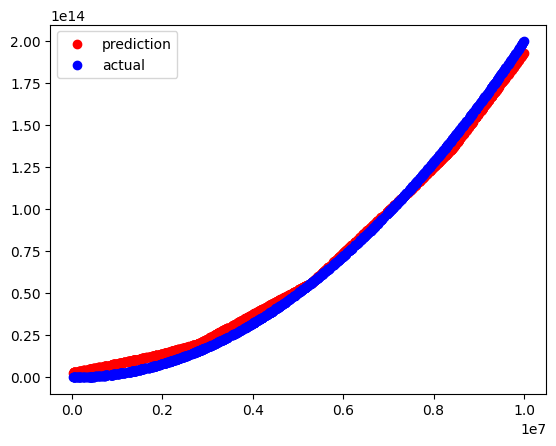

In [24]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [3]:
words = requests.get('https://www.mit.edu/~ecprice/wordlist.10000').text.splitlines()
random.shuffle(words)
content_len = 1
feature_count = 10

chars = sorted(set('.'.join(words)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

def build_dataset(words):
    X, Y = [], []
    context = [0] * content_len
    for word in words:
        word += '.'
        for c in word:
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [59]:
Xtrain, Ytrain = build_dataset(words)

C = Embedding(27, feature_count)
l1 = Linear(content_len * feature_count, 75, activation='tanh')
l2 = Linear(75, 27)

model = Model([C, l1, l2])

optim = Adam(model=model)
batch_size = 32

In [69]:
Xtrain[5]

array([5])

In [60]:
for _ in (t:=trange(300)):
    ix = np.random.randint(0, Xtrain.shape[0], (batch_size,))

    out = model(Xtrain[ix])

    expected = Ytrain[ix]

    losses = []

    for i, o in enumerate(out):
        maxVal = max([num.data for num in o])

        exp = [(math.e**(num-maxVal)) for num in o]

        count = sum([num for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(Ytrain[ix][i])].log()*-1

        losses.append(loss)
    
    batch_loss = sum(losses)/batch_size

    optim.zero_grad()

    batch_loss.backward()

    optim.step()
    
    t.set_description(f'loss: {loss.data}')

loss: 3.065154642196936: 100%|██████████| 300/300 [07:11<00:00,  1.44s/it] 


In [64]:
avg_loss = 0
countt = 0
random.shuffle(words)
for word in words[:10]:
    for ch1, ch2 in zip(word, word[1:]):
        input = [stoi[ch1]]
        expected = stoi[ch2]
        out = model(input)

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(expected)].log()*-1

        avg_loss += loss.data
        countt += 1

print(f'loss: {avg_loss/countt}')

loss: 2.7752515361916887


In [91]:
for _ in range(1):
    word = ''
    context = [0] * content_len
    while True:
        out = model(context)
        maxVal = max([num.data for num in out])
        exp = [(math.e**(num-maxVal)) for num in out]
        count = sum([num.data for num in exp])
        prob = [val.data/count for val in exp]
        ix = np.random.choice(len(prob), p=prob)
        word += itos[ix]
        context = context[1:] + [ix]
        if word[-1] == '.':
            print(word)
        break

0
